## This notebook allows to visualize HOG descriptor

For this we use transformation of HOG matrix and groupping into view that can be visualized. OpenCV natively doesn't support visualization, so we need to apply HOG descriptor transformation manually

In [1]:
# Import modules
from cv2 import (imshow, waitKey, HOGDescriptor, SIFT_create, BOWKMeansTrainer,
                 BOWImgDescriptorExtractor, BFMatcher, NORM_L2, cvtColor, COLOR_RGB2GRAY, imread, IMREAD_GRAYSCALE)
from numpy import uint8, array, reshape, hsplit, vsplit
from pathlib import Path
import numpy as np
from matplotlib import pyplot as plt
import random
from sklearn import svm
from sklearn.model_selection import train_test_split

In [2]:
def build_img_array_from_path(path):
    files = Path(path).glob('*')
    # array_imgs = array([])
    array_imgs = []
    for fn in sorted(files):
        img = imread(str(fn), IMREAD_GRAYSCALE)
        img_prep = np.array(img)
        # array_imgs = np.append(array_imgs, img)
        array_imgs.append(img_prep)

    return array_imgs

In [3]:
def hog_descriptors(imgs, size, winSizeVar, blockSizeVar, cellSizeVar):
    # Create a list to store the HOG feature vectors
    hog_features = []

    # Set parameter values for the HOG descriptor based on the image data in use
    winSize = (winSizeVar, winSizeVar)
    blockSize = (blockSizeVar, blockSizeVar)
    blockStride = (int(blockSizeVar / 2), int(blockSizeVar / 2))
    cellSize = (cellSizeVar, cellSizeVar)
    nbins = 9

    # Set the remaining parameters to their default values
    derivAperture = 1
    winSigma = -1.
    histogramNormType = 0
    L2HysThreshold = 0.2
    gammaCorrection = False
    nlevels = 64

    # Create a HOG descriptor
    hog = HOGDescriptor(winSize, blockSize, blockStride, cellSize, nbins, derivAperture, winSigma,
                        histogramNormType, L2HysThreshold, gammaCorrection, nlevels)

    # Compute HOG descriptors for the input images and append the feature vectors to the list
    for img in imgs:
        hist = hog.compute(img.reshape(size, size).astype(uint8))
        hog_features.append(hist)

    return array(hog_features)

In [4]:
def hog_visualization(img, descriptor, winSizeVar, blockSizeVar, cellSizeVar):
    winSize = (winSizeVar, winSizeVar)
    blockSize = (blockSizeVar, blockSizeVar)
    blockStride = (int(blockSizeVar / 2), int(blockSizeVar / 2))
    cell_size = (cellSizeVar, cellSizeVar)
    num_bins = 9

    print(blockStride)

    # Reshape the feature vector to [number of blocks in x and y direction, number of cells per block in x and y direction, number of bins]
    # This will be useful later when we plot the feature vector, so that the feature vector indexing matches the image indexing
    n_blockx = (winSize[0] // blockStride[0]) - 1
    n_blocky = (winSize[1] // blockStride[1]) - 1
    n_cellx = blockSize[0] // cell_size[0]
    n_celly = blockSize[1] // cell_size[1]

    hog_descriptor_reshaped = descriptor.reshape(n_blockx,
                                                 n_blocky,
                                                 n_cellx,
                                                 n_celly,
                                                 num_bins).transpose((1, 0, 2, 3, 4))

    # Create an array that will hold the average gradients for each cell
    ave_grad = np.zeros((n_blockx + 1, n_blocky + 1, num_bins))

    # Create an array that will count the number of histograms per cell
    hist_counter = np.zeros((n_blockx + 1, n_blocky + 1, 1))

    # Add up all the histograms for each cell and count the number of histograms per cell
    for i in range(n_cellx):
        for j in range(n_celly):
            ave_grad[i:n_blockx + i,
            j:n_blocky + j] += hog_descriptor_reshaped[:, :, i, j, :]

            hist_counter[i:n_blockx + i,
            j:n_blocky + j] += 1

    # Calculate the average gradient for each cell
    # print(hist_counter)
    ave_grad /= hist_counter

    # Calculate the total number of vectors we have in all the cells.
    len_vecs = ave_grad.shape[0] * ave_grad.shape[1] * ave_grad.shape[2]

    # Create an array that has num_bins equally spaced between 0 and 180 degress in radians.
    deg = np.linspace(0, np.pi, num_bins, endpoint=False)

    # Each cell will have a histogram with num_bins. For each cell, plot each bin as a vector (with its magnitude
    # equal to the height of the bin in the histogram, and its angle corresponding to the bin in the histogram).
    # To do this, create rank 1 arrays that will hold the (x,y)-coordinate of all the vectors in all the cells in the
    # image. Also, create the rank 1 arrays that will hold all the (U,V)-components of all the vectors in all the
    # cells in the image. Create the arrays that will hold all the vector positons and components.
    U = np.zeros((len_vecs))
    V = np.zeros((len_vecs))
    X = np.zeros((len_vecs))
    Y = np.zeros((len_vecs))

    # Set the counter to zero
    counter = 0

    # Use the cosine and sine functions to calculate the vector components (U,V) from their maginitudes. Remember the
    # cosine and sine functions take angles in radians. Calculate the vector positions and magnitudes from the
    # average gradient array
    for i in range(ave_grad.shape[0]):
        for j in range(ave_grad.shape[1]):
            for k in range(ave_grad.shape[2]):
                U[counter] = ave_grad[i, j, k] * np.cos(deg[k])
                V[counter] = ave_grad[i, j, k] * np.sin(deg[k])

                X[counter] = (cell_size[0] / 2) + (cell_size[0] * i)
                Y[counter] = (cell_size[1] / 2) + (cell_size[1] * j)

                counter = counter + 1

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    # Display the image
    ax1.set(title='Grayscale Image')
    ax1.imshow(img, cmap='gray')

    # Plot the feature vector (HOG Descriptor)
    ax2.set(title='HOG Descriptor')
    ax2.quiver(Y, X, U, V, color='white', headwidth=0, headlength=0, scale_units='inches', scale=3)
    ax2.invert_yaxis()
    ax2.set_aspect(aspect=1)
    ax2.set_facecolor('black')

    plt.show()

Size of HOG feature vectors: (1, 54756)
(10, 10)


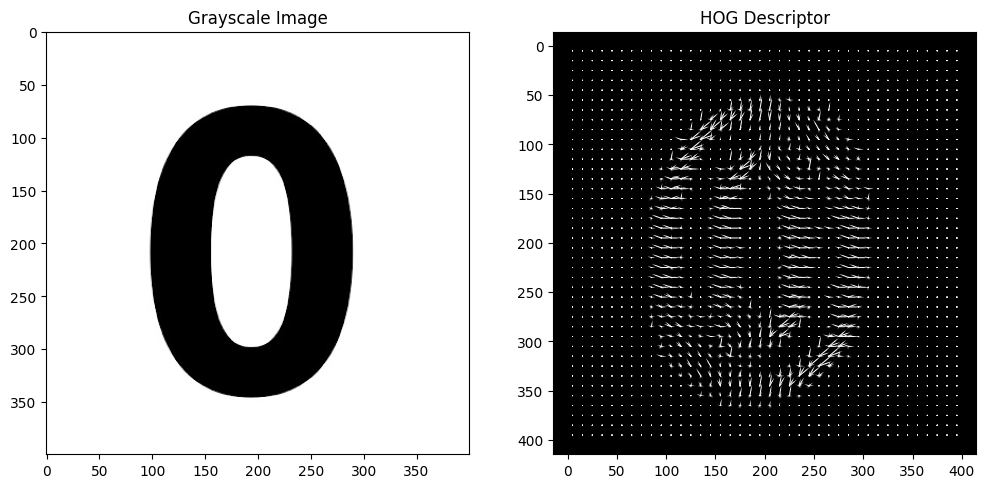

Size of HOG feature vectors: (1, 54756)
(10, 10)


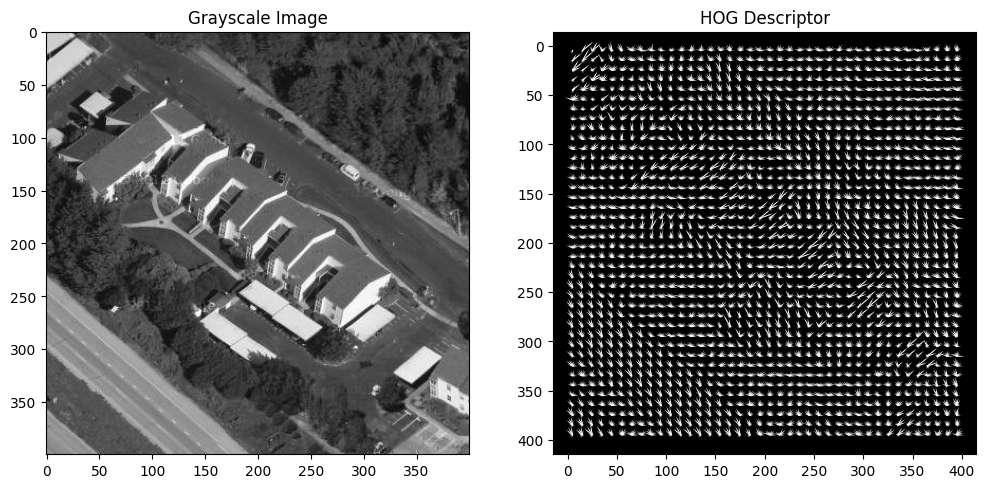

In [9]:
# configuration
size = 400
winSizeVar = 400
blockSizeVar = 20
cellSizeVar = 10

img = imread('Images/zero.jpg', IMREAD_GRAYSCALE)
rs_image_hog = hog_descriptors([img], size, winSizeVar, blockSizeVar, cellSizeVar)
print('Size of HOG feature vectors:', rs_image_hog.shape)

hog_visualization(img, rs_image_hog, winSizeVar, blockSizeVar, cellSizeVar)



sub_imgs = build_img_array_from_path("Images/RSSCN7/fResident")

img = sub_imgs[33]
rs_image_hog = hog_descriptors([img], size, winSizeVar, blockSizeVar, cellSizeVar)
print('Size of HOG feature vectors:', rs_image_hog.shape)


hog_visualization(img, rs_image_hog, winSizeVar, blockSizeVar, cellSizeVar)